In [1]:
import geopandas as gpd
import pandas as pd
import concurrent.futures
import fiona
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import shape
from shapely.geometry import box
from tqdm import tqdm
from scipy.spatial import cKDTree
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
from rasterio.features import shapes
from rasterio.mask import mask
import rasterio
import numpy as np
import yaml
import os
import seaborn as sns
from pyproj import CRS

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)



##### Find the weighted average distance to nearest dam for all AEI
Load, Reproject, Save Dam data

In [2]:
# Load the dams data and convert to GeoDataFrame
africa_dams = pd.read_csv(resolve_path(config['Africa_Dam_csv_path']))
geometry = [Point(xy) for xy in zip(africa_dams['Long__res_'], africa_dams['Lat__res_'])]
gdf_dams_deg = gpd.GeoDataFrame(africa_dams, geometry=geometry)
gdf_dams_deg = gdf_dams_deg.set_crs("EPSG:4326")  # Ensure the initial CRS is correct

# Reproject
gdf_dams = gdf_dams_deg.to_crs("EPSG:3857")

# Save reprojected dam data as .shp
gdf_dams.to_file(resolve_path(config['Africa_Dam_Reproj_shp_path']))

print(gdf_dams.head())


        Country  ISO  Long__res_  Lat__res_                          geometry
0      Zimbabwe  ZWE     30.4697   -19.9597  POINT (3391871.489 -2268257.449)
1         Benin  BEN      2.2500     8.1500     POINT (250468.854 910328.897)
2         Benin  BEN      1.8027    11.2077    POINT (200675.646 1255668.964)
3         Benin  BEN      2.2606     8.7959     POINT (251648.841 983023.981)
4  Burkina Faso  BFA     -3.2495    10.9542   POINT (-361732.685 1226913.346)


Load, Crop, Reproject, Save Irrigation data

{'driver': 'AAIGrid', 'dtype': 'float32', 'nodata': -9.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]'), 'transform': Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0)}


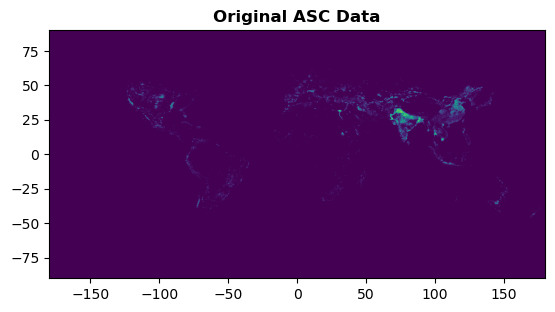

                                            geometry  raster_val
0  POLYGON ((-8.91667 38.00000, -8.91667 37.91667...   76.793549
1  POLYGON ((-8.83333 38.00000, -8.83333 37.91667...  199.917297
2  POLYGON ((-8.75000 38.00000, -8.75000 37.91667...   71.140877
3  POLYGON ((-8.66667 38.00000, -8.66667 37.91667...   29.676140
4  POLYGON ((-8.58333 38.00000, -8.58333 37.91667...  290.473785


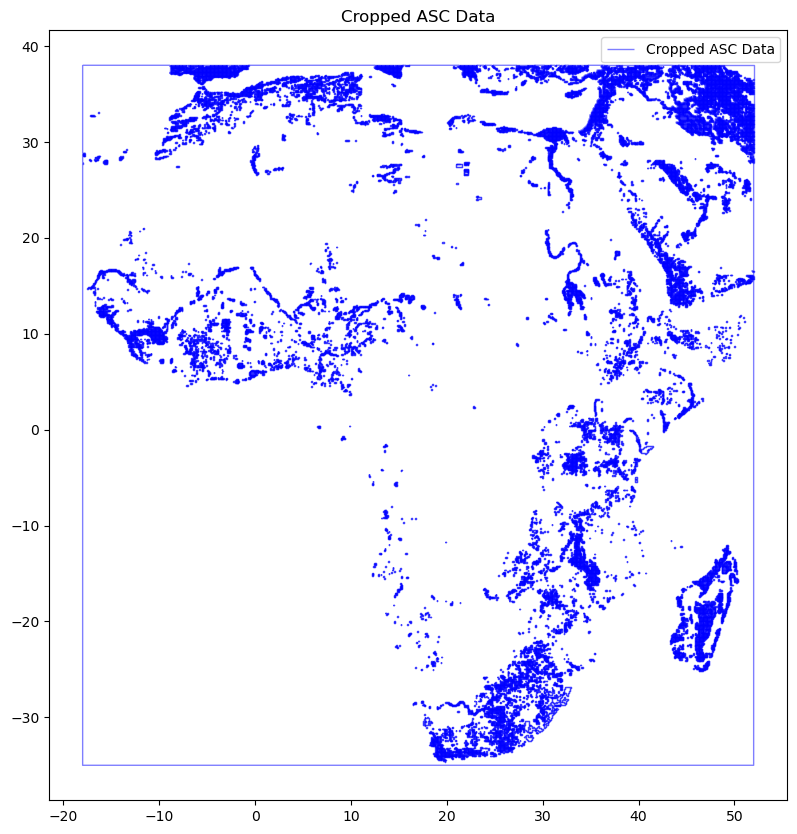

Reprojected CRS: EPSG:3857
Reprojected Bounding Box: [-2003750.83427892 -4163881.14406429  5788613.52125023  4579425.8128701 ]


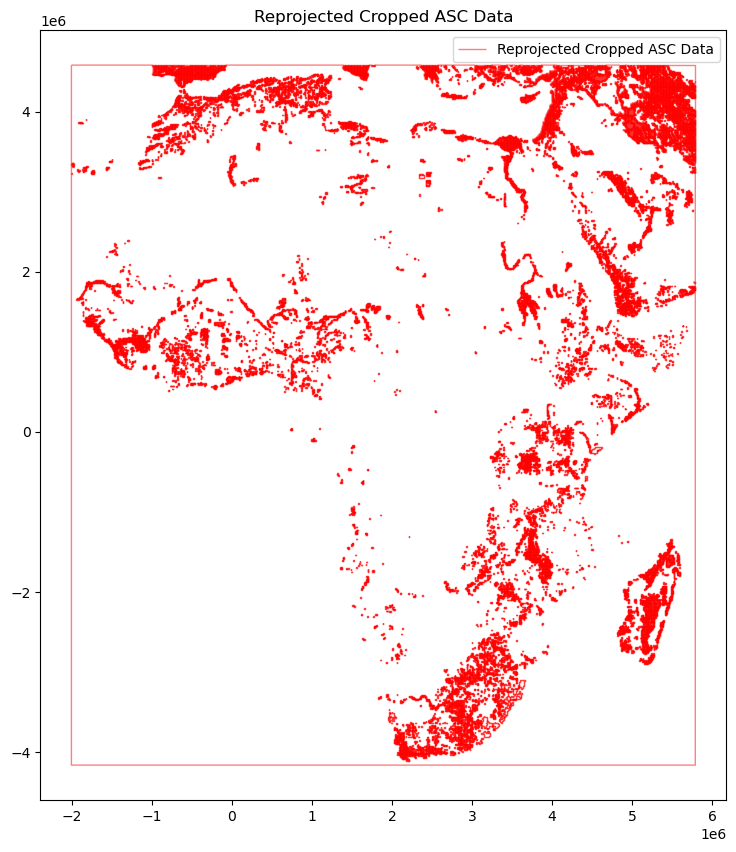

Original Geometries:
 0    POLYGON ((-8.91667 38.00000, -8.91667 37.91667...
1    POLYGON ((-8.83333 38.00000, -8.83333 37.91667...
2    POLYGON ((-8.75000 38.00000, -8.75000 37.91667...
3    POLYGON ((-8.66667 38.00000, -8.66667 37.91667...
4    POLYGON ((-8.58333 38.00000, -8.58333 37.91667...
Name: geometry, dtype: geometry
Reprojected Geometries:
 0    POLYGON ((-992598.793 4579425.813, -992598.793...
1    POLYGON ((-983322.169 4579425.813, -983322.169...
2    POLYGON ((-974045.544 4579425.813, -974045.544...
3    POLYGON ((-964768.920 4579425.813, -964768.920...
4    POLYGON ((-955492.296 4579425.813, -955492.296...
Name: geometry, dtype: geometry
GeoPackage saved to: /home/ermiller/Africa_Irrigation/Data/Processed/G_AEI_2015_Reprojected.gpkg


In [3]:
# Load and Read the ASC file
asc_file_path = resolve_path(config['Africa_AEI_2015_asc_path'])

with rasterio.open(asc_file_path) as src:
    asc_data = src.read(1)  # Read the first band
    asc_meta = src.meta
    print(asc_meta)
    show(src, title="Original ASC Data")

# Define the bounding box for Africa
africa_bbox = (-18.0, -35.0, 52.0, 38.0)  # (min_lon, min_lat, max_lon, max_lat)

# Create a bounding box geometry
bbox_geom = box(*africa_bbox)
geo = gpd.GeoDataFrame({'geometry': [bbox_geom]}, index=[0], crs='EPSG:4326')

# Reproject the bounding box to the ASC file CRS if necessary
if asc_meta['crs'] != geo.crs:
    geo = geo.to_crs(crs=asc_meta['crs'])

# Crop the ASC data using the bounding box
with rasterio.open(asc_file_path) as src:
    out_image, out_transform = mask(src, [bbox_geom], crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Save the cropped ASC data to a new file
cropped_asc_path = resolve_path(config['AEI_2015_cropped_tif_path'])
with rasterio.open(cropped_asc_path, 'w', **out_meta) as dest:
    dest.write(out_image)

# Convert the cropped ASC data to GeoDataFrame
def raster_to_geodataframe(raster_path, crs):
    with rasterio.open(raster_path) as src:
        image = src.read(1)  # Read the first band
        mask = image != src.nodata
        results = (
            {'properties': {'raster_val': v}, 'geometry': shape(s)}
            for i, (s, v) in enumerate(shapes(image, mask=mask, transform=src.transform))
        )
        geoms = list(results)
        gdf = gpd.GeoDataFrame.from_features(geoms)
        gdf.crs = crs
    return gdf

gdf_cropped_asc = raster_to_geodataframe(cropped_asc_path, asc_meta['crs'])
print(gdf_cropped_asc.head())

# Plot the cropped GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
gdf_cropped_asc.boundary.plot(ax=ax, linewidth=1, edgecolor='blue', alpha=0.5, label='Cropped ASC Data')
plt.title('Cropped ASC Data')
plt.legend()
plt.show()

# Reproject the cropped GeoDataFrame to a new CRS (EPSG:3857)
gdf_cropped_asc_reprojected = gdf_cropped_asc.to_crs(epsg=3857)

# Print CRS and bounding box after reprojection
print("Reprojected CRS:", gdf_cropped_asc_reprojected.crs)
print("Reprojected Bounding Box:", gdf_cropped_asc_reprojected.total_bounds)

# Plot the reprojected GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
gdf_cropped_asc_reprojected.boundary.plot(ax=ax, linewidth=1, edgecolor='red', alpha=0.5, label='Reprojected Cropped ASC Data')
plt.title('Reprojected Cropped ASC Data')
plt.legend()
plt.show()

# Inspect some geometries before and after reprojection
print("Original Geometries:\n", gdf_cropped_asc.geometry.head())
print("Reprojected Geometries:\n", gdf_cropped_asc_reprojected.geometry.head())

# Define the path to save the GeoPackage
geopackage_path = resolve_path(config['AEI_2015_reproj_gpkg_path'])

# Save the reprojected GeoDataFrame as a GeoPackage
gdf_cropped_asc_reprojected.to_file(geopackage_path, driver="GPKG")

print(f"GeoPackage saved to: {geopackage_path}")


Load, Reproject, Save CPIS data

In [4]:
gdf_cpis_deg = gpd.read_file(resolve_path(config['Combined_CPIS_shp_path']))
print(gdf_cpis_deg.crs)
gdf_cpis_reproj = gdf_cpis_deg.to_crs("EPSG:3857")
print(gdf_cpis_reproj.crs)

gdf_cpis_reproj.to_file(resolve_path(config['Combined_CPIS_Reproj_shp_path']))

EPSG:4326
EPSG:3857


Load, Reproject, Save country data

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f5390f0bce0>>
Traceback (most recent call last):
  File "/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


EPSG:4326
EPSG:3857


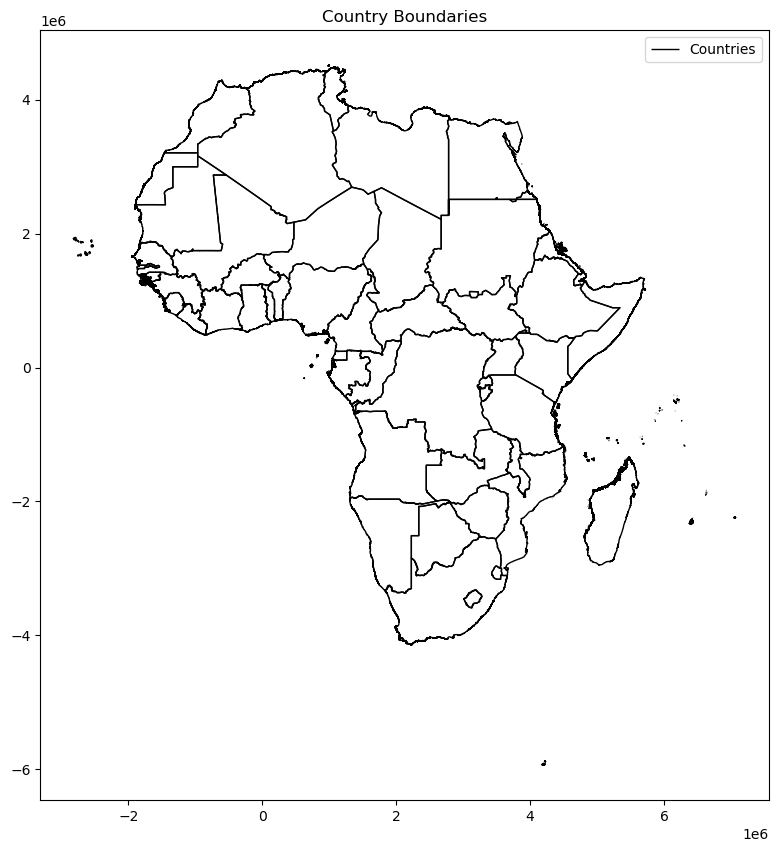

In [5]:
# Load the country shapefile and reproject
gdf_countries_deg = gpd.read_file(resolve_path(config['Africa_Countries_shp_path']))
print(gdf_countries_deg.crs)
gdf_countries_reproj = gdf_countries_deg.to_crs("EPSG:3857")
print(gdf_countries_reproj.crs)

# Save the reprojected country data
gdf_countries_reproj.to_file(resolve_path(config['Africa_Countries_Reproj_shp_path']))

# Plot country boundaries
fig, ax = plt.subplots(figsize=(10, 10))
gdf_countries_reproj.boundary.plot(ax=ax, linewidth=1, edgecolor='black', label='Countries')
plt.title('Country Boundaries')
plt.legend()
plt.show()

Sort it by country

In [6]:
# Load the reprojected country data
gdf_countries_reproj = gpd.read_file(resolve_path(config['Africa_Countries_Reproj_shp_path']))

# Load the repojected irrigation data
gdf_AEI_reproj = gpd.read_file(resolve_path(config['AEI_2015_reproj_gpkg_path']))

#gdf_asc = raster_to_geodataframe(reprojected_AEI_shp_path)
#gdf_asc = gdf_asc.set_crs(epsg=3857, allow_override=True)

# Perform spatial join
gdf_AEI_joined = gpd.sjoin(gdf_AEI_reproj, gdf_countries_reproj[['ISO3', 'geometry']], how='left', predicate='within')

# Keep only necessary columns
gdf_AEI_joined = gdf_AEI_joined[['geometry', 'raster_val', 'ISO3']]

# Save joined data
#gdf_AEI_joined.to_file(resolve_path(config['AEI_2015_by_Country_shp_path']))



# Load the reprojected dam data
gdf_dams_reproj = gpd.read_file(resolve_path(config['Africa_Dam_Reproj_shp_path']))

# Perform spatial join
gdf_dams_joined = gpd.sjoin(gdf_dams_reproj, gdf_countries_reproj, how='left', predicate='within')
gdf_dams_joined = gdf_dams_joined[['geometry', 'ISO3']]

# Save joined dam data
#gdf_dams_joined.to_file(resolve_path(config['Africa_Dam_by_Country_shp_path']))



# Load the reprojected CPIS data
gdf_cpis_reproj = gpd.read_file(resolve_path(config['Combined_CPIS_Reproj_shp_path']))

# Perform spatial join
gdf_cpis_joined = gpd.sjoin(gdf_cpis_reproj, gdf_countries_reproj, how='left', predicate='within')
gdf_cpis_joined = gdf_cpis_joined[['geometry', 'ISO3']]

# Save the joined data
#gdf_cpis_joined.to_file(resolve_path(config['Combined_CPIS_by_Country_shp_path']))


In [7]:
print(gdf_AEI_joined.head())
print(gdf_dams_joined.head())
print(gdf_cpis_joined.head())

                                            geometry  raster_val ISO3
0  POLYGON ((-992598.793 4579425.813, -992598.793...   76.793549  NaN
1  POLYGON ((-983322.169 4579425.813, -983322.169...  199.917297  NaN
2  POLYGON ((-974045.544 4579425.813, -974045.544...   71.140877  NaN
3  POLYGON ((-964768.920 4579425.813, -964768.920...   29.676140  NaN
4  POLYGON ((-955492.296 4579425.813, -955492.296...  290.473785  NaN
                           geometry ISO3
0  POINT (3391871.489 -2268257.449)  ZWE
1     POINT (250468.854 910328.897)  BEN
2    POINT (200675.646 1255668.964)  BEN
3     POINT (251648.841 983023.981)  BEN
4   POINT (-361732.685 1226913.346)  BFA
                                            geometry ISO3
0  POLYGON ((2158598.021 -4057555.506, 2158658.42...  ZAF
1  POLYGON ((2158740.433 -4056950.848, 2158788.75...  ZAF
2  POLYGON ((2286656.768 -4053677.724, 2286693.00...  ZAF
3  POLYGON ((2285644.300 -4053175.531, 2285704.69...  ZAF
4  POLYGON ((2184297.066 -4052314.792, 21843

Calculate Sum of Distances from each CPIS to point to the Nearest Dam

In [8]:
def sum_distance_to_nearest(src_gdf, target_gdf):
    src_points = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    if len(target_points) == 0:
        return 0  # Return 0 if there are no target points to avoid errors
    
    tree = cKDTree(target_points)
    dists, _ = tree.query(src_points, k=1)
    
    return np.sum(dists)

# Sum distances for CPIS to nearest dam
sum_distances_cpis = sum_distance_to_nearest(gdf_cpis_joined, gdf_dams_joined)

Calculate Average Distance of All AEI to Nearest Dam for Each Country

In [9]:
def avg_distance_to_nearest_by_country(src_gdf, target_gdf):
    src_points = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    if len(target_points) == 0:
        return 0  # Return 0 if there are no target points to avoid errors

    tree = cKDTree(target_points)
    dists, _ = tree.query(src_points, k=1)
    
    return np.mean(dists)

avg_distances_AEI_by_country = gdf_AEI_joined.groupby('ISO3').apply(lambda group: avg_distance_to_nearest_by_country(group.drop(columns=['ISO3']), gdf_dams_joined[gdf_dams_joined['ISO3'] == group['ISO3'].iloc[0]]))


/tmp/ipykernel_3684892/3584901145.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_distances_AEI_by_country = gdf_AEI_joined.groupby('ISO3').apply(lambda group: avg_distance_to_nearest_by_country(group.drop(columns=['ISO3']), gdf_dams_joined[gdf_dams_joined['ISO3'] == group['ISO3'].iloc[0]]))


Calculate the Targeting Ratio

In [10]:
# Count the number of CPIS in each country
cpis_count_by_country = gdf_cpis_joined['ISO3'].value_counts()

# Ensure that both series contain the same countries
common_iso3 = cpis_count_by_country.index.intersection(avg_distances_AEI_by_country.index)

# Calculate the denominator
denominator = sum(cpis_count_by_country[iso3] * avg_distances_AEI_by_country[iso3] for iso3 in common_iso3)

# Compute the targeting ratio
overall_targeting_ratio = sum_distances_cpis / denominator
print(f"Targeting Ratio: {overall_targeting_ratio}")


Targeting Ratio: 1.5391196859613916


Calculate Targeting Ratio at Different Thresholds

/tmp/ipykernel_3684892/3101634230.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_distances_AEI_by_country = gdf_AEI_joined.groupby('ISO3', group_keys=False).apply(avg_distance_to_nearest)
/tmp/ipykernel_3684892/3101634230.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_distances_AEI_by_country = gdf_AEI_joined.groupby('ISO3', group_keys=False).apply(avg_distance_to_nearest)
/tmp/ipykernel

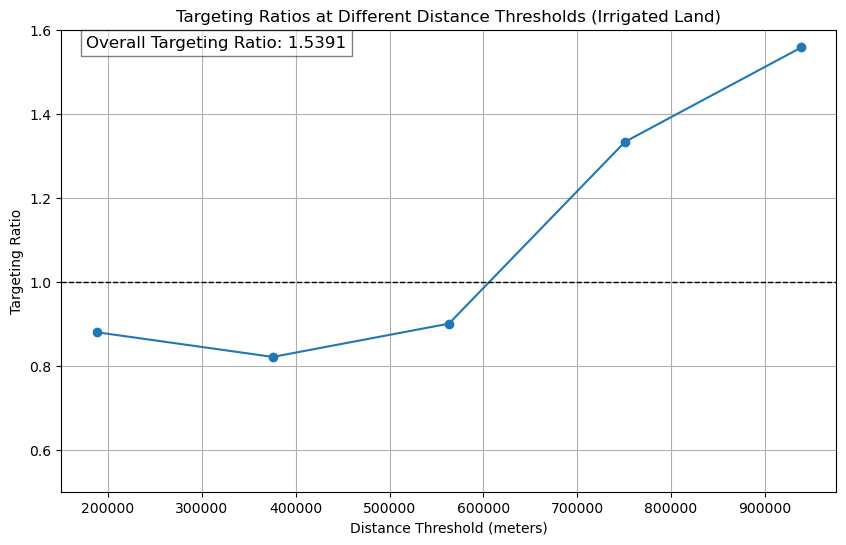

In [14]:
# Function to calculate distances to nearest target
def calculate_distances(src_gdf, target_gdf):
    src_centroids = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    if target_points.shape[0] == 0 or src_centroids.shape[0] == 0:
        return np.array([])  # Return empty array if there are no points
    
    tree = cKDTree(target_points)
    dists, _ = tree.query(src_centroids, k=1)
    
    return dists


# Calculate distances for CPIS to nearest dam
distances_cpis_to_dams = calculate_distances(gdf_cpis_joined, gdf_dams_joined)

# Compute the maximum distance
max_distance = np.max(distances_cpis_to_dams)

# Define thresholds by splitting the maximum distance into 5 intervals
thresholds = np.linspace(0, max_distance, 6)[1:]  # Create 5 thresholds

# Calculate the targeting ratio for each threshold
targeting_ratios = []

for threshold in thresholds:
    # Filter distances for CPIS to nearest dam
    filtered_distances_cpis = distances_cpis_to_dams[distances_cpis_to_dams <= threshold]
    sum_distances_cpis = np.sum(filtered_distances_cpis)
    
    # Calculate average distances of AEI to nearest dam by country
    def avg_distance_to_nearest(group):
        distances = calculate_distances(group, gdf_dams_joined[gdf_dams_joined['ISO3'] == group['ISO3'].iloc[0]])
        filtered_distances = distances[distances <= threshold]
        if len(filtered_distances) > 0:
            return np.mean(filtered_distances)
        else:
            return np.nan

    # Exclude grouping columns
    avg_distances_AEI_by_country = gdf_AEI_joined.groupby('ISO3', group_keys=False).apply(avg_distance_to_nearest)
    
    # Filter out NaNs
    avg_distances_AEI_by_country = avg_distances_AEI_by_country.dropna()
    
    # Count the number of CPIS in each country
    cpis_count_by_country = gdf_cpis_joined['ISO3'].value_counts()
    
    # Ensure that both series contain the same countries
    common_iso3 = cpis_count_by_country.index.intersection(avg_distances_AEI_by_country.index)
    
    # Calculate the denominator
    denominator = sum(cpis_count_by_country[iso3] * avg_distances_AEI_by_country[iso3] for iso3 in common_iso3)
    
    # Compute the targeting ratio
    targeting_ratio = sum_distances_cpis / denominator if denominator != 0 else np.nan
    targeting_ratios.append(targeting_ratio)


# Plot targeting ratios at different thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, targeting_ratios, marker='o', linestyle='-')
plt.title('Targeting Ratios at Different Distance Thresholds (Irrigated Land)')
plt.xlabel('Distance Threshold (meters)')
plt.ylabel('Targeting Ratio')
plt.ylim(0.5, 1.6)  # Set y-axis limits
plt.grid(True)

# Add text box with overall targeting ratio
textstr = f'Overall Targeting Ratio: {overall_targeting_ratio:.4f}'
plt.gcf().text(0.15, 0.85, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Add horizontal line at y=1
plt.axhline(y=1, color='black', linestyle='--', linewidth=1)

plt.show()


/tmp/ipykernel_3626969/1503940600.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


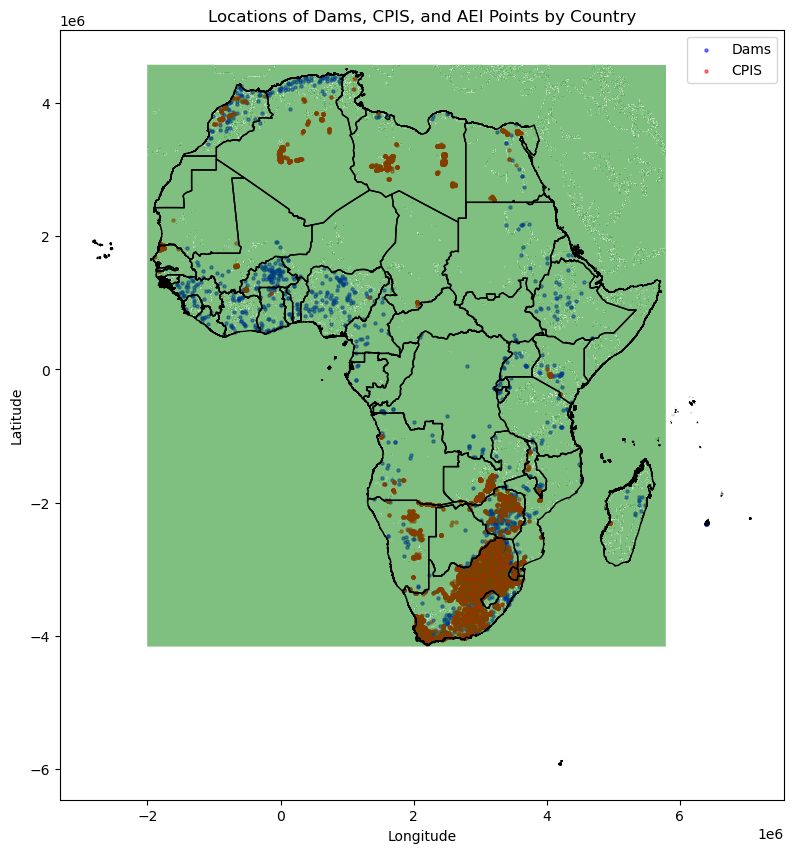

In [ ]:
# Plot dams, CPIS, and AEI points
fig, ax = plt.subplots(figsize=(15, 10))

# Plot country boundaries
gdf_countries_reproj.boundary.plot(ax=ax, linewidth=1, color='black')

# Plot dams
gdf_dams_joined.plot(ax=ax, markersize=5, color='blue', alpha=0.5, label='Dams')

# Plot CPIS
gdf_cpis_joined.centroid.plot(ax=ax, markersize=5, color='red', alpha=0.5, label='CPIS')

# Plot AEI points
gdf_AEI_joined.plot(ax=ax, markersize=5, color='green', alpha=0.5, label='AEI')

plt.legend()
plt.title('Locations of Dams, CPIS, and AEI Points by Country')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


##### Consider Distribution of Distance Data

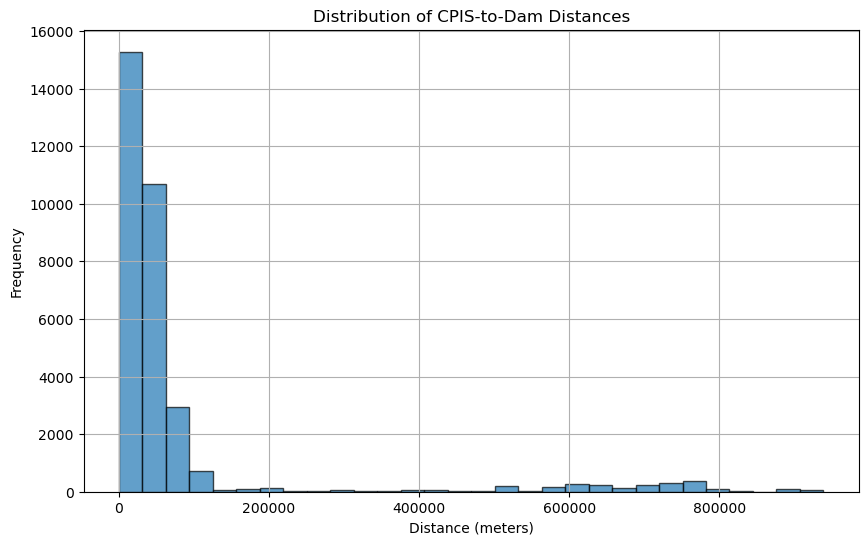

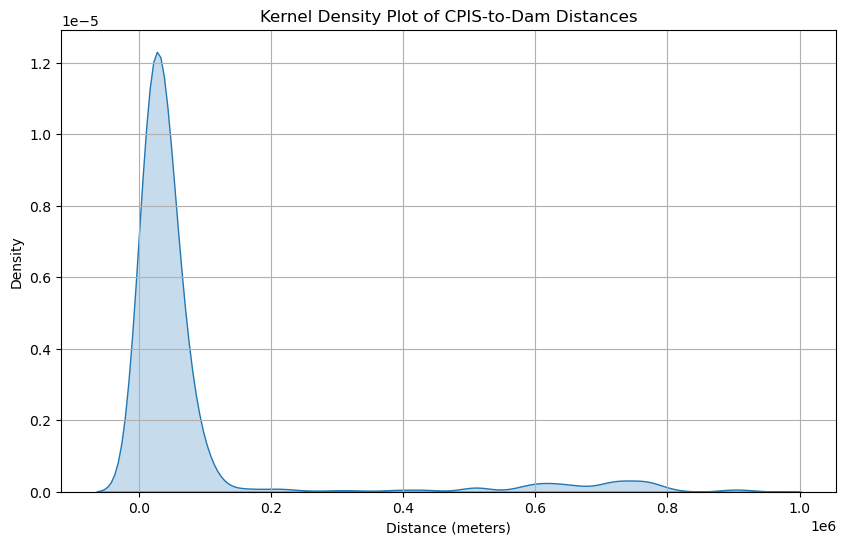

In [ ]:

# Histogram of CPIS-to-dam distances
plt.figure(figsize=(10, 6))
plt.hist(distances_cpis_to_dams, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of CPIS-to-Dam Distances')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Kernel Density Plot of CPIS-to-dam distances
plt.figure(figsize=(10, 6))
sns.kdeplot(distances_cpis_to_dams, fill=True)
plt.title('Kernel Density Plot of CPIS-to-Dam Distances')
plt.xlabel('Distance (meters)')
plt.ylabel('Density')
plt.grid(True)
plt.show()


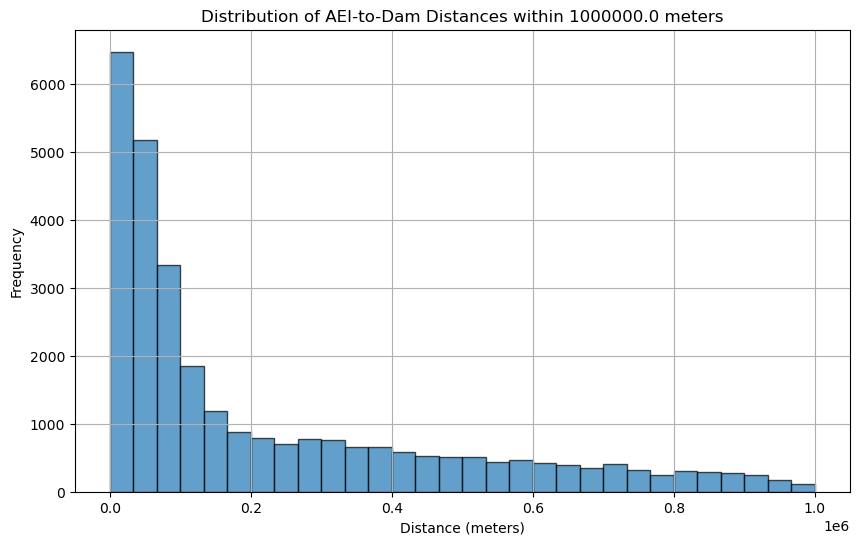

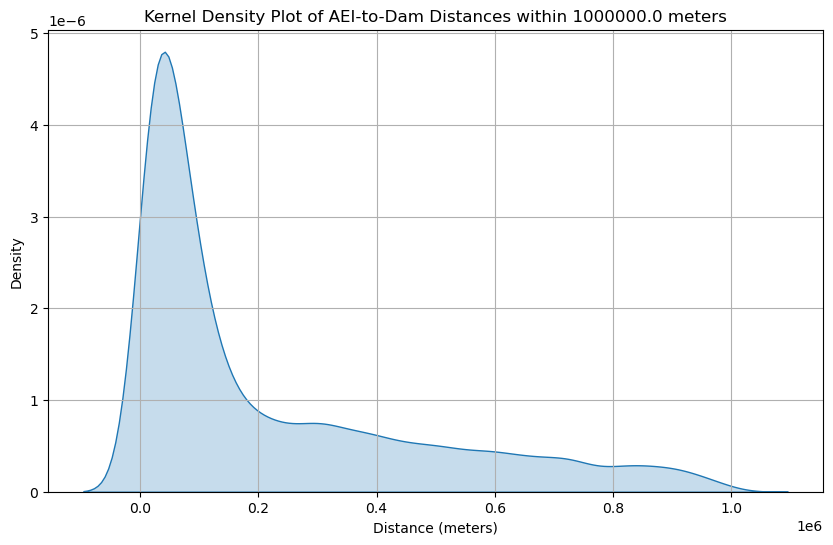

In [ ]:
threshold = 1.0e6
# Filter distances for AEI to nearest dam within the threshold
AEI_distances = calculate_distances(gdf_AEI_joined, gdf_dams_joined)
filtered_AEI_distances = AEI_distances[AEI_distances <= threshold]

# Histogram of AEI-to-dam distances
plt.figure(figsize=(10, 6))
plt.hist(filtered_AEI_distances, bins=30, edgecolor='black', alpha=0.7)
plt.title(f'Distribution of AEI-to-Dam Distances within {threshold} meters')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Kernel Density Plot of AEI-to-dam distances within the threshold
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_AEI_distances, fill=True)
plt.title(f'Kernel Density Plot of AEI-to-Dam Distances within {threshold} meters')
plt.xlabel('Distance (meters)')
plt.ylabel('Density')
plt.grid(True)
plt.show()
